# Empirical project
## Financial Econometrics I
### Summer semester 2021/2022
#### Jan Kubal & Matyáš Mattanelli

In this project we compare and evaluate volatility forecasting perfomance of various models on the provided data set capturing information about stock prices of Amazon.com, Inc. The project contains four sections. The first one describes the data, the second one compares in-sample fit of all models, the third section performs forecasting and evaluates the results, and the last section provides a summary of the findings.

In [9]:
#Loading necessary libraries
#install.packages(c("xts", "ggplot2", "forecast", "ggpubr", "tseries", "highfrequency", "rugarch"))
suppressPackageStartupMessages({
    library(xts)
    library(ggplot2)
    library(forecast)
    library(ggpubr)
    library(tseries)
    library(highfrequency)
    library(rugarch)
    library(moments)
})

In [4]:
#Loading the assigned data
load("31.RData")

### 1. Data description

In the current section, we provide an overview of the provided data set. We start with the summary statistics.

In [6]:
#Summary statistics
summary(amzn)
print(paste(nrow(amzn), "observations available", sep = " "), quote = F)

     Index                 ret                   RV          
 Min.   :2010-01-05   Min.   :-0.1583988   Min.   :0.004511  
 1st Qu.:2011-07-04   1st Qu.:-0.0094187   1st Qu.:0.011693  
 Median :2013-01-10   Median : 0.0007216   Median :0.014087  
 Mean   :2013-01-08   Mean   : 0.0009774   Mean   :0.015531  
 3rd Qu.:2014-07-14   3rd Qu.: 0.0112673   3rd Qu.:0.017605  
 Max.   :2016-01-22   Max.   : 0.1634040   Max.   :0.075159  
      RV_p               RV_n                RS                 RK        
 Min.   :0.003344   Min.   :0.002976   Min.   :-7.84155   Min.   : 2.228  
 1st Qu.:0.008134   1st Qu.:0.007791   1st Qu.:-0.52719   1st Qu.: 3.749  
 Median :0.009985   Median :0.009700   Median : 0.07361   Median : 4.774  
 Mean   :0.010929   Mean   :0.010795   Mean   : 0.09625   Mean   : 6.007  
 3rd Qu.:0.012715   3rd Qu.:0.012278   3rd Qu.: 0.69644   3rd Qu.: 6.586  
 Max.   :0.056156   Max.   :0.071117   Max.   : 5.67825   Max.   :66.378  

[1] "1500 observations available"


As can be seen, the returns series appears to attain reasonable values. Both the mean and the median are quite close to zero and the first and third quantile have similar absolute magnitudes suggesting that the distribution may be symmetric. As for the Realized Volatility, it attains strictly positive values and it looks quite symetric as well. The same applies to Realized Positive and Negative Semi-volatility. The values of Realized Skewness and Realized Kurtosis suggest that the data are often far from normal distribution. Before proceeding to plotting the data, we will inspect the returns a bit more closely.

In [11]:
#Skewness
print(paste("Skewness of returns: ", round(skewness(amzn$ret), 2)))
#Kurtosis
print(paste("Kurtosis of returns: ", round(kurtosis(amzn$ret), 2)))
#Stationarity
adf.test(amzn$ret)

[1] "Skewness of returns:  0.13"
[1] "Kurtosis of returns:  13.56"


Warning message in adf.test(amzn$ret):
"p-value smaller than printed p-value"



	Augmented Dickey-Fuller Test

data:  amzn$ret
Dickey-Fuller = -11.542, Lag order = 11, p-value = 0.01
alternative hypothesis: stationary


The results above suggest that the distribution of returns is indeed far from normal. The skewness is nearly zero and the kurtosis is very high. On the other hand, the Augmented Dickey-Fuller test rejects the null hypothesis of the series containing a unit root in favor of the alternative of stationarity. We can confirm these findings by looking at the plots.

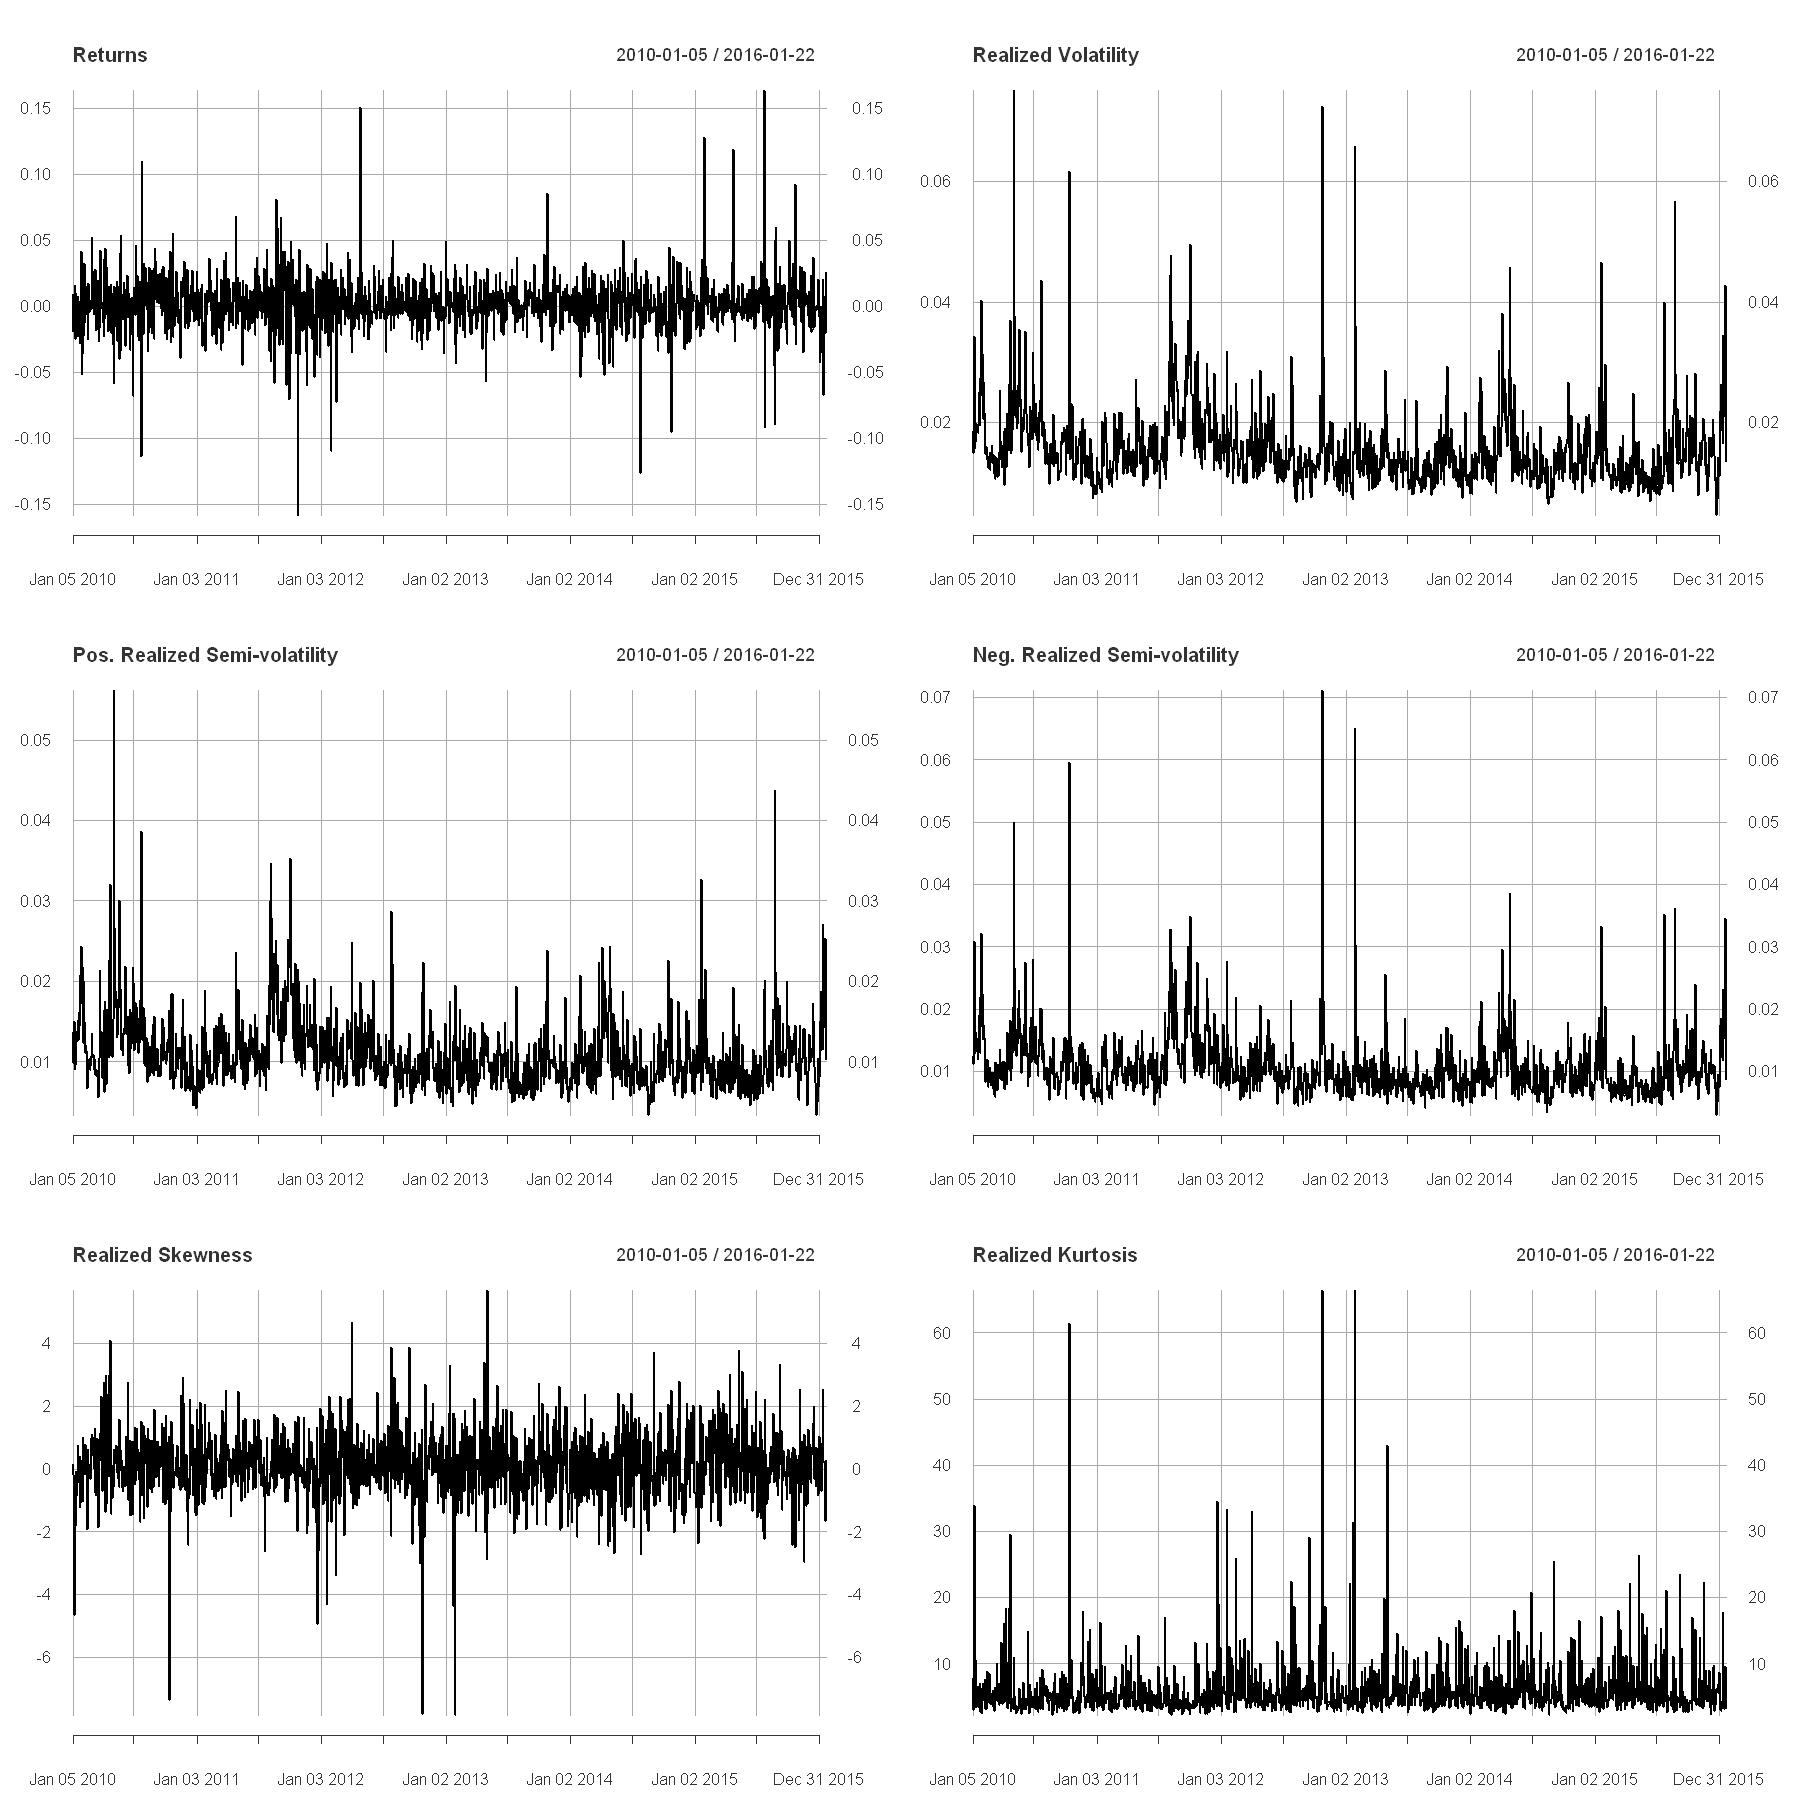

In [14]:
#Basic plots
options(repr.plot.width = 15, repr.plot.height = 15)
plot_names <- c("Returns", "Realized Volatility", "Pos. Realized Semi-volatility", "Neg. Realized Semi-volatility", "Realized Skewness", "Realized Kurtosis")
par(mfrow = c(3, 2))
for (i in 1:6) {
  print(plot(amzn[, i], main = plot_names[i]))
}

From the plot of the return series it appears that the returns are indeed mean-stationary. However, we can observe some variance clustering. For illustration purposes, we also present some plots combining the returns with Realized Volatility and also a plot with both Semi-volatilities.

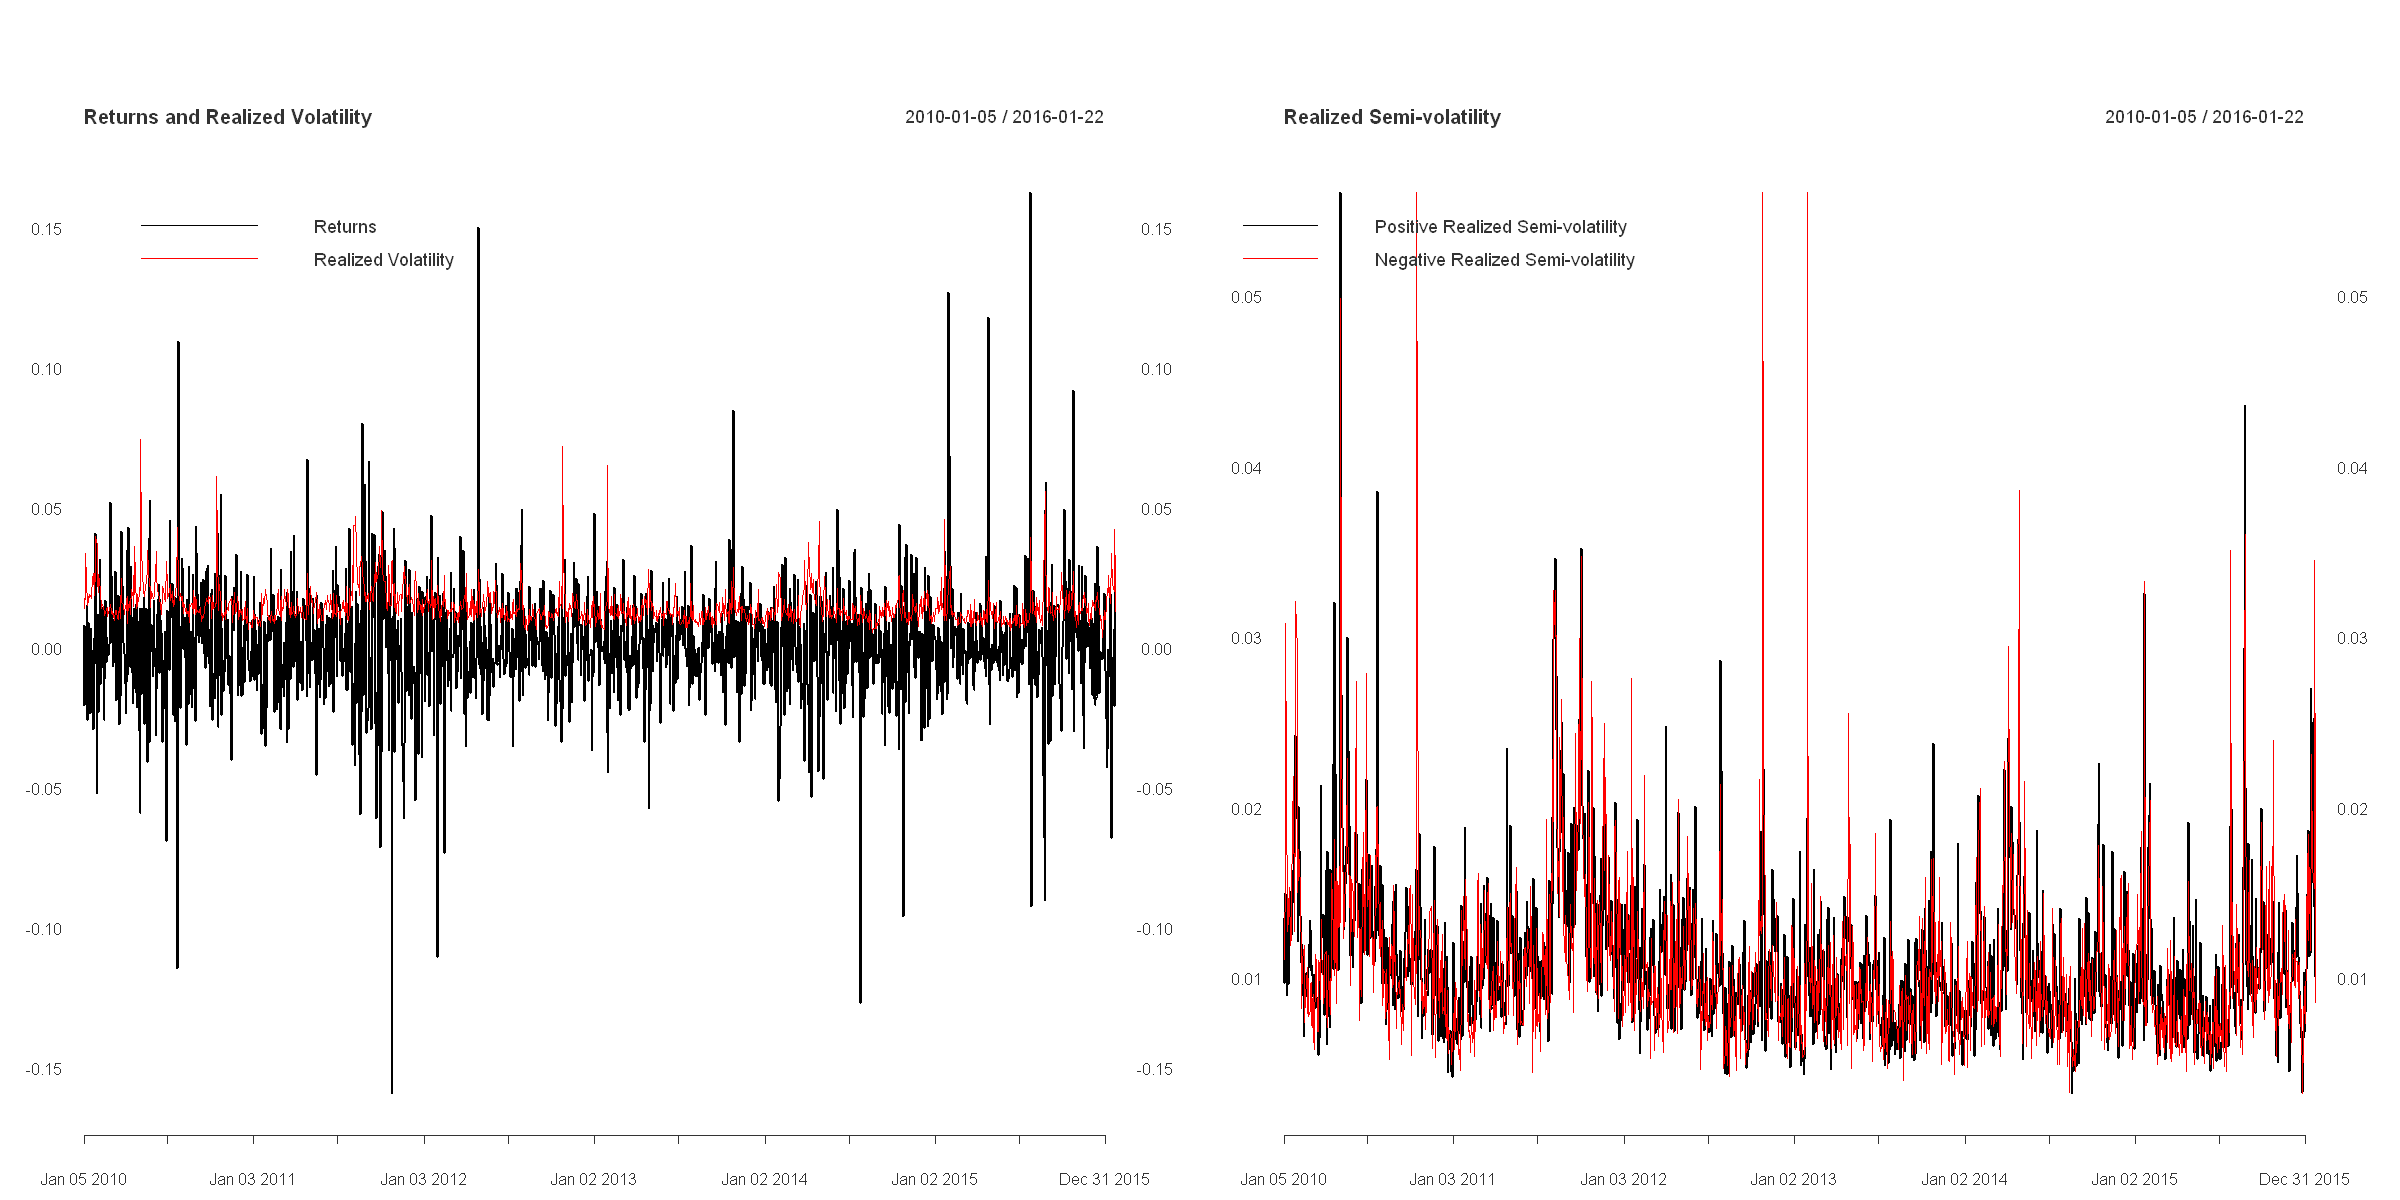

In [19]:
options(repr.plot.width = 20, repr.plot.height = 10)
par(mfrow = c(1, 2))
#Returns and Realized Volatility
plot_holder <- plot(amzn$ret, main = "Returns and Realized Volatility", grid.col = NA)
plot_holder <- lines(amzn$RV, col = "red")
plot_holder <- addLegend("topleft", on = 1, legend.names = c("Returns", "Realized Volatility"), col = c("black", "red"), lty = 1, bty = "n")
plot_holder
#Positive and negative realized semi-volatility
plot_holder <- plot(amzn$RV_p, main = "Realized Semi-volatility", grid.col = NA)
plot_holder <- lines(amzn$RV_n, col = "red")
plot_holder <- addLegend("topright", on = 1, legend.names = c("Positive Realized Semi-volatility", "Negative Realized Semi-volatility"), col = c("black", "red"), lty = 1, bty = "n")
plot_holder

In the next step, we will inspect the dependencies in each series by calculating the Autocorrelation Function (ACF) and the Partial Autocorrelation function (PACF).

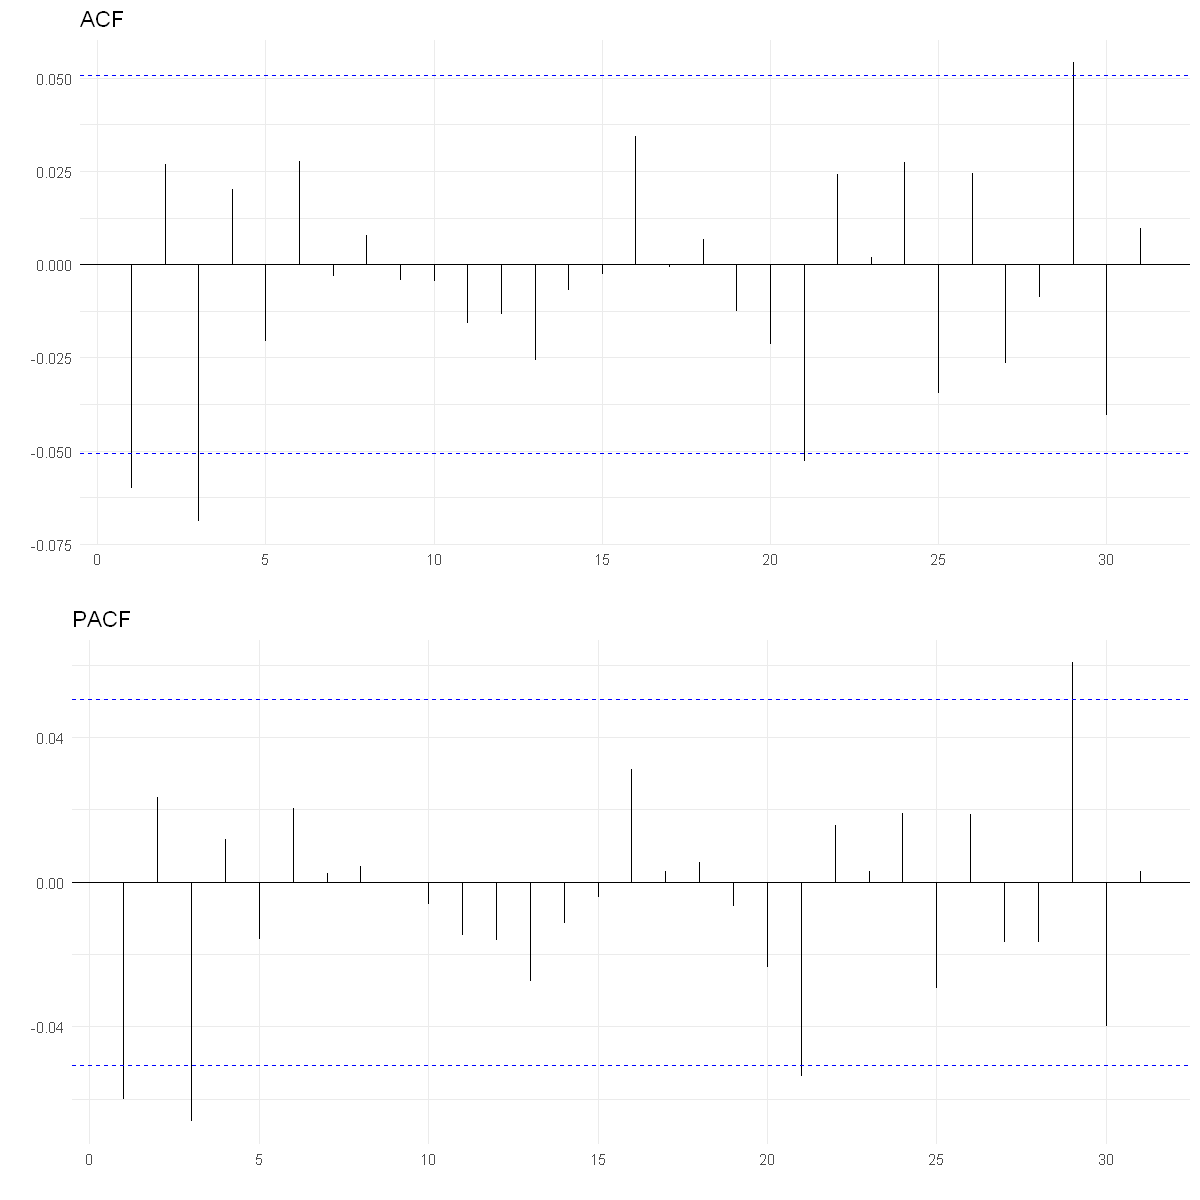

In [21]:
options(repr.plot.width = 10, repr.plot.height = 10)
#ACF and PACF for returns
acf_ret <- ggAcf(amzn$ret)+
  theme_minimal()+
  ggtitle("ACF")+
  ylab("")+
  xlab("")
pacf_ret <- ggPacf(amzn$ret)+
  theme_minimal()+
  ggtitle("PACF")+
  ylab("")+
  xlab("")
ggarrange(acf_ret, pacf_ret, ncol = 1, nrow = 2)

We can see that there are some significant autocorrelations which is something we will keep in mind during ARMA modelling.

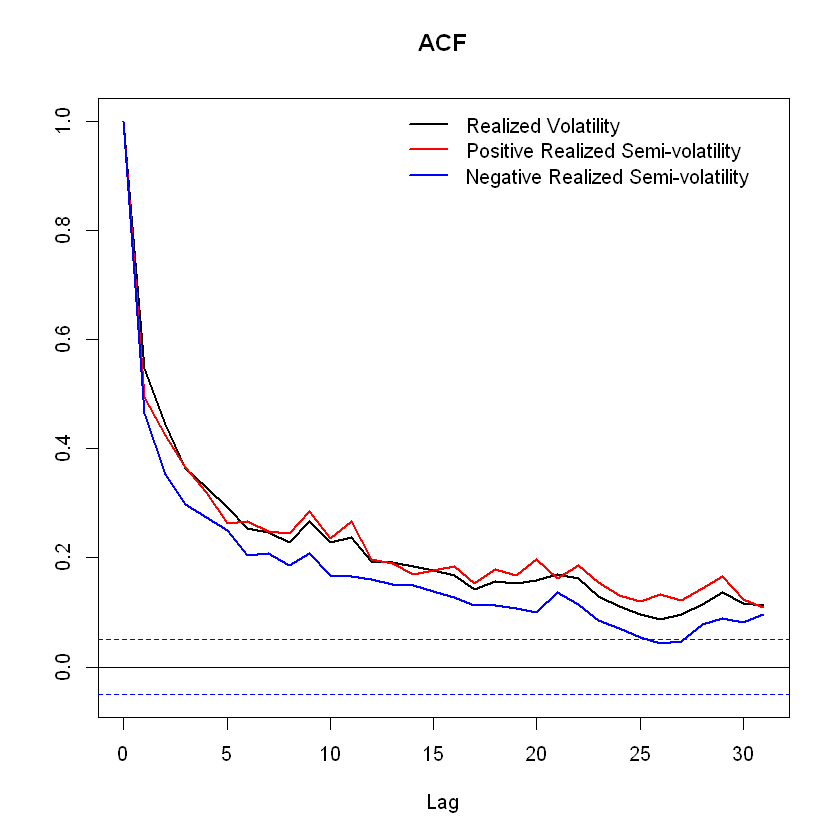

In [23]:
options(repr.plot.width = 7, repr.plot.height = 7)
#ACF and PACF for Realized Volatility
acf_RV <- acf(amzn$RV, plot = F)
acf_RV_p <-  acf(amzn$RV_p, plot = F)
acf_RV_n <-  acf(amzn$RV_n, plot = F)
plot(acf_RV, type = "l", main = "ACF", ylab = "", lwd = 2)
lines(x = acf_RV_p$lag, y = acf_RV_p$acf, col = "red", lwd = 2)
lines(x = acf_RV_n$lag, y = acf_RV_n$acf, col = "blue", lwd = 2)
legend("topright", legend = c("Realized Volatility", "Positive Realized Semi-volatility", "Negative Realized Semi-volatility"), col = c("black", "red", "blue"), bty = "n", lty = 1, lwd = 2)

The figure above shows the ACF for Realized Volatility and Semi-volatilities. The results suggests that all three series are strongly autocorrelated. The line representing Negative Realized Semi-volatility is below the other two suggesting the it is slightly less dependent.

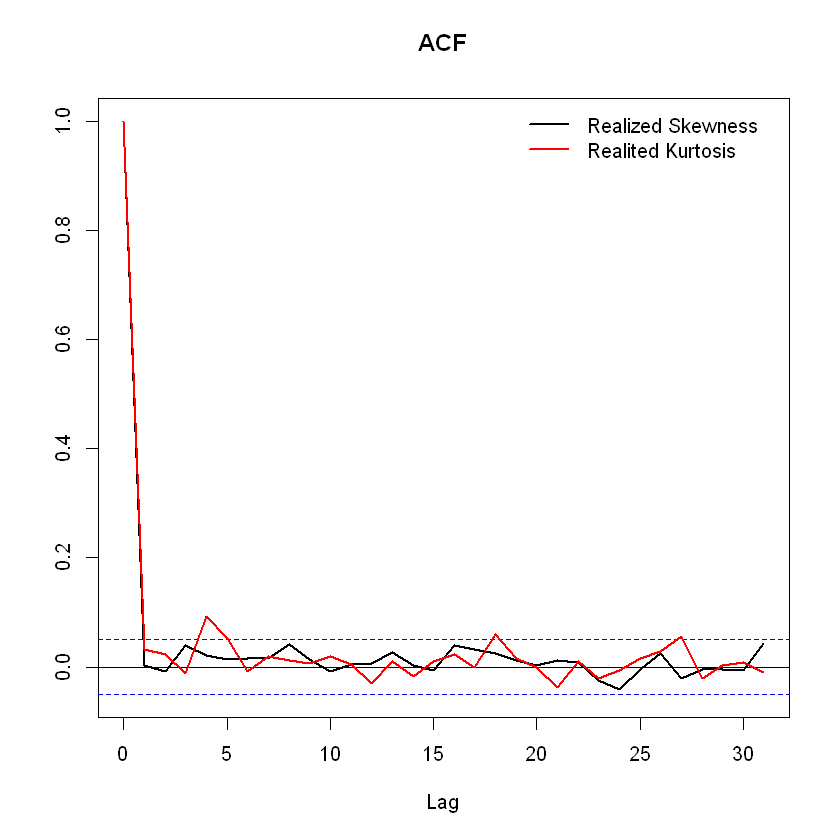

In [24]:
#ACF and PACF for Realized Skewness and Kurtosis
acf_RS <- acf(amzn$RS, plot = F)
acf_RK <-  acf(amzn$RK, plot = F)
plot(acf_RS, type = "l", main = "ACF", ylab = "", lwd = 2)
lines(x = acf_RK$lag, y = acf_RK$acf, col = "red", lwd = 2)
legend("topright", legend = c("Realized Skewness", "Realited Kurtosis"), col = c("black", "red"), bty = "n", lty = 1, lwd = 2)

As for Realized Skewness and Kurtosis, there appear to be only a few significant dependencies.

### 2. In-sample fit

In this section, we estimate 6 models in total on the provided data and inspect the differences between in-sample fits.

#### Realized Volatility - AR(1)

The first model is a simple autoregressive process which takes the following form:
$$
RV_t = \alpha + \beta RV_{t-1} + \epsilon_t,
$$
where $RV_t$ is Realized Volatility and $\epsilon_t \sim N(0,\sigma^2)$.

In [25]:
#Realized Volatility - AR(1)
amzn$RV_lag <- lag(amzn$RV) #Adding the first lag of RV to the data
ar1_rv <- lm(RV ~ RV_lag, data = amzn) #OLS estimation
summary(ar1_rv)


Call:
lm(formula = RV ~ RV_lag, data = amzn)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.026926 -0.002979 -0.000668  0.001815  0.057279 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.0070328  0.0003632   19.36   <2e-16 ***
RV_lag      0.5469940  0.0216356   25.28   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.005336 on 1497 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.2992,	Adjusted R-squared:  0.2988 
F-statistic: 639.2 on 1 and 1497 DF,  p-value: < 2.2e-16


As we can see, the coefficient on the lag is highly statistically significant. Considering the magnitude of the coefficient, Realized Volatility does not appear to be highly persistent. The Adjusted R-squared is quite high as well. We can now plot the fitted values and compare them to actual values. 

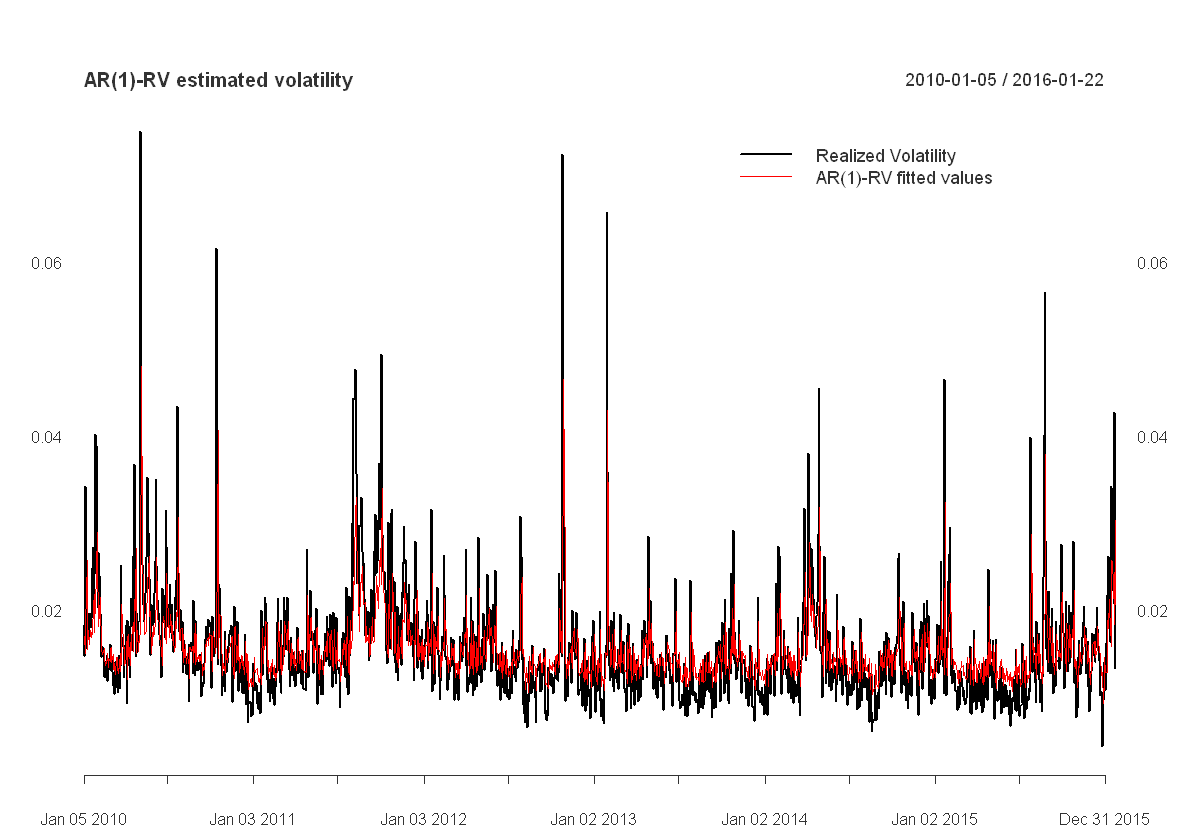

In [28]:
options(repr.plot.width = 10, repr.plot.height = 7)
#Plotting fitted values
ar1_fitted <- xts(fitted.values(ar1_rv), order.by = as.Date(names(fitted.values(ar1_rv))))
plot_holder <- plot(amzn$RV, main = "AR(1)-RV estimated volatility", grid.col = NA)
plot_holder <- lines(ar1_fitted, col = "red")
plot_holder <- addLegend("topright", on = 1, legend.names = c("Realized Volatility", "AR(1)-RV fitted values"), col = c("black", "red"), lty = 1, bty = "n", lwd = c(2, 1))
plot_holder

The predictions seem to fit the data quite well. However, there are some large jumps in Realized Volatility that the model fails to capture.